In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier

import sys
from dataclasses import dataclass

import numpy as np 
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler, OrdinalEncoder, RobustScaler
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import LinearRegression

from src.exception import CustomException
from src.logger import logging
import os
from sklearn.compose import ColumnTransformer
import pandas as pd


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


In [2]:
# Fixing the directory path 
import os
os.chdir("C:/Users/RAZER BLADE/Downloads/AI Path/Multi-Class-Classification")

In [3]:
data = pd.read_csv("Datasets/train.csv")

# Modular Pipelines

# Imputing Nan values

In [4]:
def imputing_numerical(X_train_num, X_test_num, n_neighbors=10):
        imputer = IterativeImputer(estimator=LinearRegression(), max_iter=10, random_state = 0)
        #imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, random_state=42), max_iter=10, random_state=42)
        #imputer = KNNImputer(n_neighbors=n_neighbors)
        
        imputer.fit(X_train_num)
        X_train_num_imputed = imputer.transform(X_train_num)
        X_test_num_imputed = imputer.transform(X_test_num)

        X_train_num_imputed = pd.DataFrame(X_train_num_imputed)
        X_train_num_imputed.columns = X_train_num.columns
        X_test_num_imputed = pd.DataFrame(X_test_num_imputed)
        X_test_num_imputed.columns = X_test_num.columns
        return X_train_num_imputed, X_test_num_imputed

# Imputing with the mode 
def imputing_categorical(df_fill):
    for col in df_fill.columns:
        if df_fill[col].isna().any():
            df_fill.loc[:, col] = df_fill[col].fillna(df_fill[col].mode()[0])
    return df_fill

# Imputing with a new category = Missing
def imputing_categorical_with_missing(df_fill):
    for col in df_fill.columns:
        if df_fill[col].isna().any():
            df_fill[col] = df_fill[col].fillna('Missing')
    return df_fill






# Encoding 

In [12]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

def encoding_mixed(X_train_cat_imputed, X_test_cat_imputed):
    # Initialize lists to store column names for one-hot and ordinal encoding
    onehot_cols = []
    ordinal_cols = []
    
    # Loop through the columns to classify them
    for col in X_train_cat_imputed.columns:
        unique_vals = X_train_cat_imputed[col].nunique()
        
        if col.lower() == 'stage':  
            continue  # Do not encode 'Stage'
        elif unique_vals == 2:  
            ordinal_cols.append(col)  # Binary categorical → Ordinal encoding
        else:
            onehot_cols.append(col)  # Other categorical → One-hot encoding
    
    # Define the transformers for one-hot and ordinal encoding
    transformers = []
    
    if onehot_cols:
        transformers.append(('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_cols))
    
    if ordinal_cols:
        transformers.append(('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols))
    
    # Create the ColumnTransformer
    column_transformer = ColumnTransformer(transformers, remainder='passthrough')

    # Fit the transformer on the training set and transform both datasets
    X_train_encoded = column_transformer.fit_transform(X_train_cat_imputed)
    X_test_encoded = column_transformer.transform(X_test_cat_imputed)

    # Convert the transformed data back into a DataFrame with proper column names
    all_columns = []
    if onehot_cols:
        onehot_feature_names = column_transformer.named_transformers_['onehot'].get_feature_names_out(onehot_cols)
        all_columns.extend(onehot_feature_names)
    
    all_columns.extend(ordinal_cols)
    all_columns.extend([col for col in X_train_cat_imputed.columns if col not in onehot_cols + ordinal_cols])

    # Convert NumPy arrays to DataFrame with numerical values
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=all_columns, index=X_train_cat_imputed.index)
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=all_columns, index=X_test_cat_imputed.index)

    # Ensure all non-'Stage' columns are numeric
    for col in X_train_encoded.columns:
        if col.lower() != 'stage':
            X_train_encoded[col] = pd.to_numeric(X_train_encoded[col], errors='coerce')
            X_test_encoded[col] = pd.to_numeric(X_test_encoded[col], errors='coerce')

    return X_train_encoded, X_test_encoded

def target_encoding(Y):
    code = {'C':0,'CL':2, 'D':1}
    Y = Y.map(code)
    return Y

# Scaling 

In [13]:
def scaling(X_train, X_test):
    X_train_tf = X_train.copy()
    X_test_tf = X_test.copy()

    log_features = ['N_Days', 'Bilirubin', 'Cholesterol', 'Alk_Phos', 'SGOT', 'Tryglicerides']
    numerical_features = [col for col in X_train.select_dtypes('float').columns if col not in log_features]
    
    # only scale numeric varaibles in this case rather than the dummy variables for categories 
    rob = RobustScaler()
    X_train_tf.loc[:, numerical_features] = rob.fit_transform(X_train_tf.loc[:, numerical_features])
    X_test_tf.loc[:, numerical_features] = rob.transform(X_test_tf.loc[:, numerical_features])

    # log 
    X_train_tf.loc[:, log_features] = X_train_tf.loc[:, log_features].apply(np.log1p)
    X_test_tf.loc[:, log_features] = X_test_tf.loc[:, log_features].apply(np.log1p)


    return X_train_tf, X_test_tf


# Feature Engineering 

In [14]:
def feature_engineering_numerical(X_num):
    
    #X_num.loc[:, 'N_Years'] = X_num['N_Days'] / 365
    X_num['Bilirubin / Albumin'] = X_num['Bilirubin'] / X_num['Albumin']
    X_num['SGOT / Platelets'] = X_num['SGOT'] / X_num['Platelets']
    X_num['ISH'] = 0.4 * X_num['Cholesterol'] + 0.4 * X_num['Tryglicerides'] + 0.2 * X_num['Albumin']
    X_num['Coagulation_Score'] = X_num['Prothrombin'] / X_num['Platelets']

    return X_num

def feature_engineering_categorical(X_cat):
    #X_cat["Severe_Water_Retention"] = (X_cat["Edema"]  & X_cat["Ascites"])
    return X_cat

# Basic preprocessing 

In [28]:
def preprocess_train(data): 
    # set the column Stage to object 
    data['Stage'] = data['Stage'].astype(object)

    # replacing weird values of variables 
    data.loc[data['Hepatomegaly'] == '119.35', 'Hepatomegaly'] = data['Hepatomegaly'].mode()[0]
    data.loc[data['Ascites'] == 'S', 'Ascites'] = data['Ascites'].mode()[0]
    data.loc[data['Ascites'] == 'D-penicillamine', 'Ascites'] = data['Ascites'].mode()[0]

    # Delete where N_Days > Age
    data = data[data['Age']>data['N_Days']] 

    return data

def preprocess_test(data): 
    # set the column Stage to object 
    data['Stage'] = data['Stage'].astype(object)

    # replacing weird values of variables 
    data.loc[data['Hepatomegaly'] == '119.35', 'Hepatomegaly'] = data['Hepatomegaly'].mode()[0]
    data.loc[data['Ascites'] == 'S', 'Ascites'] = data['Ascites'].mode()[0]
    data.loc[data['Ascites'] == 'D-penicillamine', 'Ascites'] = data['Ascites'].mode()[0]

    data.loc[data['Spiders'] == 'C', 'Spiders'] = data['Spiders'].mode()[0]
    data.loc[data['Drug'] == 'Drug', 'Drug'] = data['Drug'].mode()[0]
    # Delete where N_Days > Age
    #data = data[data['Age']>data['N_Days']] 

    return data


# Global Transformation function 

In [22]:
def initiate_data_transformation(dataset):

    dataset = preprocess_train(dataset)

    # Specifiyng columns
    target_column_name = "Status"
    numerical_columns = ['N_Days', 'Bilirubin', 'Cholesterol', 
                        'Albumin', 'Copper', 'Alk_Phos',
                        'SGOT', 'Tryglicerides', 'Platelets', 
                        'Prothrombin', 'Age']
    categorical_columns = ['Stage','Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
    columns_delete = ['id']


    # Splitting the matrices 
    Y = dataset[target_column_name]
    X = dataset.drop([target_column_name] + columns_delete, axis=1)


    # Preparing the X_train, Y_train, X_test, Y_test with stratified method
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    #X_train, X_test, Y_train, Y_test = train_test_split(
    #X, Y, test_size=0.2, random_state=8, stratify=Y)


    # SPLITTING Categorical and numerical 
    # Train 
    X_train_num = X_train[numerical_columns]
    X_train_cat = X_train[categorical_columns]
    # Test 
    X_test_num = X_test[numerical_columns]
    X_test_cat = X_test[categorical_columns]



    # Imputing Data (Null Values)
    # For numerical Features 
    X_train_num_imputed, X_test_num_imputed = imputing_numerical(X_train_num, X_test_num)

    # For Categorical Features
    X_train_cat_imputed, X_test_cat_imputed = imputing_categorical_with_missing(X_train_cat), imputing_categorical_with_missing(X_test_cat)
    #X_train_cat_imputed, X_test_cat_imputed = imputing_categorical(X_train_cat), imputing_categorical(X_test_cat)
    
                

    # Feature engineering 

    # Encoding Categorical Features
    onehot_cols = ['Edema']  # one-hot encoded column names
    ordinal_cols = ['Drug', 'Sex', 'Stage', 'Hepatomegaly','Spiders','Ascites']  # ordinal encoded column names
    X_train_cat_encoded, X_test_cat_encoded = encoding_mixed(X_train_cat_imputed, X_test_cat_imputed)#, onehot_cols, ordinal_cols)
    

    # Target Encoding 
    Y_train_final = target_encoding(Y_train)
    Y_test_final = target_encoding(Y_test)
    
    # Custom Feature functions 
    X_train_num_ft, X_test_num_ft = feature_engineering_numerical(X_train_num_imputed), feature_engineering_numerical(X_test_num_imputed) 
    X_train_cat_ft, X_test_cat_ft = feature_engineering_categorical(X_train_cat_encoded), feature_engineering_categorical(X_test_cat_encoded)



    # Scaling numerical Features
    X_train_tf, X_test_tf = scaling(X_train_num_ft, X_test_num_ft)
    

    # Final concatenation of numerical and categorical features into one Dataset

    X_train_final = pd.concat([X_train_tf.reset_index().drop('index', axis=1), X_train_cat_ft.reset_index().drop('index', axis=1)], axis=1)
    X_test_final = pd.concat([X_test_tf.reset_index().drop('index', axis=1), X_test_cat_ft.reset_index().drop('index', axis=1)], axis=1)

    # droping some columns 
    X_train_final['Stage'] = X_train_final['Stage'].astype(float)
    X_test_final['Stage'] = X_test_final['Stage'].astype(float)
    #X_train_final = X_train_final.drop(['Drug'], axis=1)
    #X_test_final = X_test_final.drop(['Drug'], axis=1)


    return (
        X_train_final,
        X_test_final,
        Y_train_final,
        Y_test_final
    )

In [44]:
X_train_final, X_test_final, Y_train_final, Y_test_final = initiate_data_transformation(data)

## Cheking the final Data 

In [45]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11972 entries, 0 to 11971
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   N_Days                11972 non-null  float64
 1   Bilirubin             11972 non-null  float64
 2   Cholesterol           11972 non-null  float64
 3   Albumin               11972 non-null  float64
 4   Copper                11972 non-null  float64
 5   Alk_Phos              11972 non-null  float64
 6   SGOT                  11972 non-null  float64
 7   Tryglicerides         11972 non-null  float64
 8   Platelets             11972 non-null  float64
 9   Prothrombin           11972 non-null  float64
 10  Age                   11972 non-null  float64
 11  Bilirubin / Albumin   11972 non-null  float64
 12  SGOT / Platelets      11972 non-null  float64
 13  ISH                   11972 non-null  float64
 14  Coagulation_Score     11972 non-null  float64
 15  Drug_D-penicillamin

## Model Trainer

### Evaluation functions 

In [46]:
# log loss function 
def log_loss(Y_test, y_pred_proba):

    # Normaliser les probabilités
    y_pred_proba = y_pred_proba / np.sum(y_pred_proba, axis=1, keepdims=True)
    
    # Éviter les extrêmes du logarithme
    epsilon = 1e-15
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)

    N = Y_test.shape[0]
    M = y_pred_proba.shape[1]
    y_one_hot = np.zeros((N, M))
    y_one_hot[np.arange(N), Y_test] = 1
    
    # Calcul de la log-vraisemblance
    log_loss = -np.sum(y_one_hot * np.log(y_pred_proba)) / Y_test.shape[0]
    
    return log_loss

# Evaluation function with multiple metrics 
def evaluate_model(Y_test, Y_pred, y_pred_proba):

    loglosss = log_loss(Y_test, y_pred_proba)
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='micro')
    recall = recall_score(Y_test, Y_pred, average='micro')
    f1 = f1_score(Y_test, Y_pred, average='micro')
    
    return accuracy, precision, recall, f1, loglosss



## Logistic Regression : Multiclass

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold


# Define stratified K-Fold for handling imbalanced data
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
j = 1
# Iterate over K-Fold splits
for train_index, test_index in k_fold.split(X_train_final, Y_train_final):
    X_train, X_valid = X_train_final.iloc[train_index], X_train_final.iloc[test_index]
    y_train, y_valid = Y_train_final.iloc[train_index], Y_train_final.iloc[test_index]
    
    # Define model
    model = LogisticRegression(multi_class='multinomial', solver='newton-cg')

    # Train model (without eval_set)
    
    model.fit(X_train, y_train)
    
    # Prédiction
    y_pred_proba = model.predict_proba(X_valid)



    # Calcul de la log_loss
    logloss = log_loss(y_valid, y_pred_proba)
    print(f"Log Loss: on validation on fold {j}", logloss)
    j+=1




# Prédiction
y_pred_proba = model.predict_proba(X_test_final)

# Calcul de la log_loss\
logloss = log_loss(Y_test_final, y_pred_proba)
print("Log Loss: on test ", logloss)

Log Loss: on validation on fold 1 0.4153162322048874
Log Loss: on validation on fold 2 0.436377855497847
Log Loss: on validation on fold 3 0.4352899162950249
Log Loss: on validation on fold 4 0.4318236912091091
Log Loss: on validation on fold 5 0.4598089266946395
Log Loss: on test  0.4476129446952683


#### Insights : 
- Tree Based models will be better.


##  Trying Other models 

In [48]:
# Initialize the set of models 
from imblearn.ensemble import EasyEnsembleClassifier
from catboost import CatBoostClassifier
import lightgbm as lgbm
from sklearn.ensemble import HistGradientBoostingClassifier

models = {
    'Random Forest': RandomForestClassifier(n_estimators=1000, random_state=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=10),
    'xgboost': XGBClassifier(n_estimators=100, objective= 'multi_logloss', learning_rate=0.7, random_state=10),
    'LGBM' : lgbm.LGBMClassifier(metric = 'multi_logloss', max_depth=9, n_estimators=300, objective='multiclass', verbose=0),
    'CatBoostClassifier': CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, loss_function='MultiClass', verbose=0),
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(learning_rate=0.05, l2_regularization=0.1, random_state=10)
}

def trainning_models(models, X_train, Y_train, X_test, Y_test):
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, Y_train) # Train model

        # Make predictions
        Y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        # Evaluate Test dataset
        accuracy, precision, recall, f1, logloss = evaluate_model(Y_test, Y_pred, y_pred_proba)
        print(model)
        print("Accuracy: {0}".format(accuracy))
        print("Precision: {0}".format(precision))
        print("Recall: {0}".format(recall))
        print("f1: {0}".format(f1))
        print("logloss: {0}".format(logloss))
        
        # Confusion Matrix
        #cm = confusion_matrix(Y_test, Y_pred)
        #plt.figure()
        #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(Y_test.unique()), yticklabels=list(Y_test.unique()))
        #plt.xlabel('Predicted')
        #plt.ylabel('Actual')
        #plt.title('Confusion Matrix')
        #plt.xticks(rotation=0)
        #plt.tight_layout()
        #plt.gca().xaxis.set_label_position('top')  # Move x-axis label to the top
        #plt.gca().xaxis.tick_top()                # Move x-axis ticks to the top
        #plt.show()

        print('='*35)
        print('\n')

In [19]:
trainning_models(models, X_train_final, Y_train_final.to_numpy(), X_test_final, Y_test_final)

RandomForestClassifier(n_estimators=1000, random_state=10)
Accuracy: 0.8406813627254509
Precision: 0.8406813627254509
Recall: 0.8406813627254509
f1: 0.8406813627254509
logloss: 0.4061134451805869


GradientBoostingClassifier(random_state=10)
Accuracy: 0.8483633934535738
Precision: 0.8483633934535738
Recall: 0.8483633934535738
f1: 0.8483633934535738
logloss: 0.3965655980497228




ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Drug_D-penicillamine: object, Drug_Missing: object, Drug_Placebo: object, Ascites_Missing: object, Ascites_N: object, Ascites_Y: object, Hepatomegaly_Missing: object, Hepatomegaly_N: object, Hepatomegaly_Y: object, Spiders_Missing: object, Spiders_N: object, Spiders_Y: object, Edema_N: object, Edema_S: object, Edema_Y: object, Sex: object, Stage: object

# Selecting best model to explain Data and improve performance 

In [20]:
# This is a function to optimize 
from catboost import CatBoostClassifier


def model_fit(X_new, Y_train, X_test_final, Y_test_final):


    # Define stratified K-Fold for handling imbalanced data
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Iterate over K-Fold splits
    for train_index, test_index in k_fold.split(X_train_final, Y_train_final):
        X_train, X_valid = X_train_final.iloc[train_index], X_train_final.iloc[test_index]
        y_train, y_valid = Y_train_final.iloc[train_index], Y_train_final.iloc[test_index]
    
    # Define model
        model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, loss_function='MultiClass', verbose=0)

    # Train model (without eval_set)
    
        model.fit(X_train, y_train)
    
    # Prédiction
        y_pred_proba = model.predict_proba(X_valid)



    # Calcul de la log_loss
        logloss = log_loss(y_valid, y_pred_proba)
        print("Log Loss: on validation  ", logloss)




# Prédiction
    y_pred_proba = model.predict_proba(X_test_final)

# Calcul de la log_loss\
    logloss = log_loss(Y_test_final, y_pred_proba)
    print("Log Loss: on test ", logloss)
 

model_fit(X_train_final, Y_train_final, X_test_final, Y_test_final)

Log Loss: on validation   0.36104609635855583
Log Loss: on validation   0.38942560320936387
Log Loss: on validation   0.3898659326280433
Log Loss: on validation   0.3858737450471191
Log Loss: on validation   0.4053539002119765
Log Loss: on test  0.38823056780353943


# Features explainability and importance

In [19]:
# Entraînement d'un modèle basique
model = model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, loss_function='MultiClass', verbose=0)
model.fit(X_train_final, Y_train_final)


In [20]:
# Récupérer l'importance des features
importances = model.get_feature_importance(prettified=True)
threshold = 1.0
selected_features = importances[importances['Importances']>threshold]

importances



,Feature Id,Importances
0,Age,11.581855
1,N_Days,11.211061
2,Prothrombin,9.712208
3,Bilirubin / Albumin,7.756262
4,Alk_Phos,5.693130
5,Bilirubin,5.505758
6,Copper,5.284689
7,SGOT,5.279649
8,Albumin,4.822600
9,Platelets,4.035323


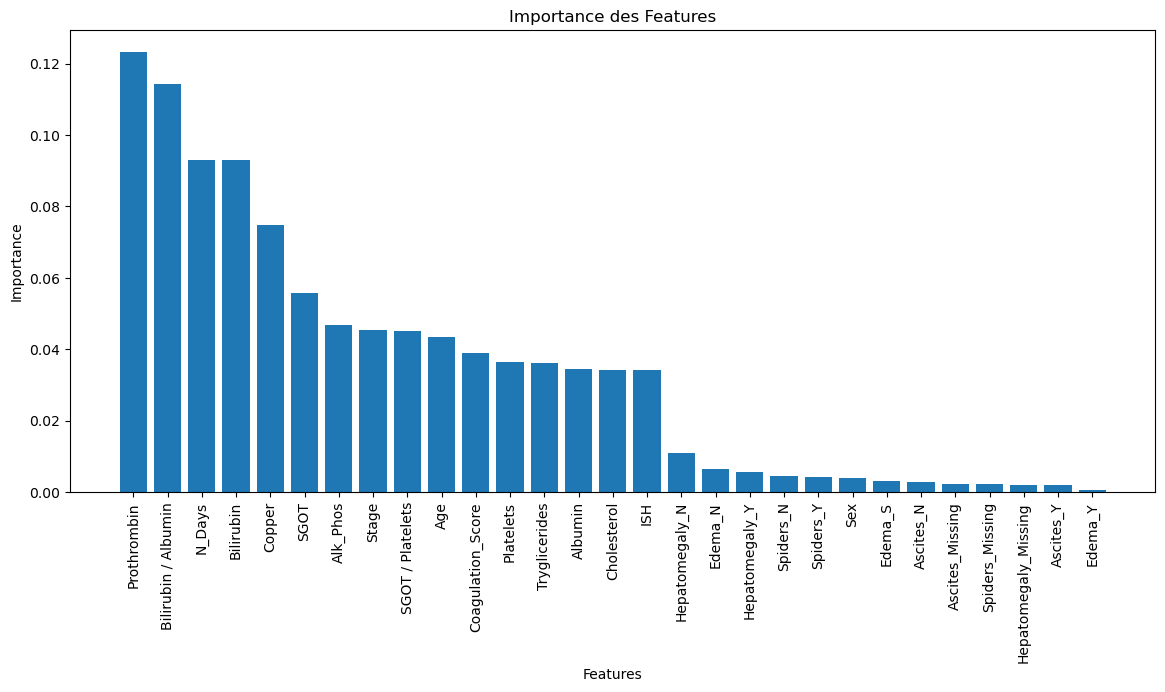

Nombre de features sélectionnées : 17
Features sélectionnées : ['Prothrombin', 'Bilirubin / Albumin', 'N_Days', 'Bilirubin', 'Copper', 'SGOT', 'Alk_Phos', 'Stage', 'SGOT / Platelets', 'Age', 'Coagulation_Score', 'Platelets', 'Tryglicerides', 'Albumin', 'Cholesterol', 'ISH', 'Hepatomegaly_N']


In [ ]:
# Entraînement d'un modèle basique
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_final, Y_train_final)

# Récupérer l'importance des features
importances = model.feature_importances_
features = X_train_final.columns

# Trier les features par importance
indices = np.argsort(importances)[::-1]


# Affchage des importances de toutes les features
plt.figure(figsize=(14, 6))
plt.title("Importance des Features")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()





## Feature selction

In [ ]:
# Définir le seuil d'importance des features
threshold = 0.01

# Sélectionner les features importantes
selected_features = [features[i] for i in indices if importances[i] > threshold]

# Afficher les features sélectionnées
print("Nombre de features sélectionnées :", len(selected_features))
print("Features sélectionnées :", selected_features)
model_fit(X_train_final[selected_features], Y_train_final, X_test_final, Y_test_final)


# Model Hyper-tunning

#### Using RandomsearchCV

In [ ]:

param_grid = {
    'iterations': [300, 700, 1000],  
    'depth': [4, 7, 10],  
    'learning_rate': [0.03, 0.08, 0.1],  
    'l2_leaf_reg': [2, 6],  
    'bagging_temperature': [0.8, 1.2],  
}




from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define XGBoost classifier
cat = CatBoostClassifier(loss_function='MultiClass')



# Randomized search
random_search = RandomizedSearchCV(estimator=cat, param_distributions=param_grid, 
                                   n_iter=100, cv=5, verbose=2, n_jobs=-1, 
                                   scoring='neg_log_loss', random_state=42)

# Fit model (Assuming X_train, y_train are defined)
random_search.fit(X_train_final, Y_train_final)

# Best parameters and model
print("Best parameters:", random_search.best_params_)
best_model = random_search.best_estimator_




In [ ]:
best_model.fit(X_train_final,Y_train_final)
Y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)

    # Evaluate Test dataset
accuracy, precision, recall, f1, logloss = evaluate_model(Y_test_final, Y_pred, y_pred_proba)
print("logloss: {0}".format(logloss))

In [ ]:
#!pip install scikit-optimize

### Using BayesSearchCV

In [ ]:
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Define XGBoost model
xgb = XGBClassifier(
    tree_method="hist",  # Optimized for performance
    eval_metric="mlogloss",  # Log loss for multiclass classification
    use_label_encoder=False
)

# Bayesian Search Parameter Grid
param_grid = {
    'n_estimators': (100, 1000),  # Number of boosting rounds
    'max_depth': (3, 12),  # Tree depth
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Log scale for better selection
    'subsample': (0.5, 1.0),  # Fraction of data per tree
    'colsample_bytree': (0.5, 1.0),  # Fraction of features per tree
    'gamma': (0, 2.0),  # Minimum loss reduction
    'min_child_weight': (1, 10),  # Minimum sum of instance weight
    'reg_lambda': (0.01, 10.0, 'log-uniform'),  # L2 regularization
    'reg_alpha': (0.01, 10.0, 'log-uniform'),  # L1 regularization
}

# Define Bayesian Optimization Search
bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=param_grid,
    scoring='neg_log_loss',  # Minimizing log loss
    n_iter=30,  # Adjust based on time and resources
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Fit model (Assuming X_train, y_train are defined)
bayes_search.fit(X_train_final, Y_train_final)

# Best parameters and model
print("Best parameters:", bayes_search.best_params_)
best_model = bayes_search.best_estimator_

best_model.fit(X_train_final,Y_train_final)
Y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)

    # Evaluate Test dataset
accuracy, precision, recall, f1, logloss = evaluate_model(Y_test_final, Y_pred, y_pred_proba)
print("logloss: {0}".format(logloss))


# Ensembling Methods 

In [128]:
# !pip install lightgbm 

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold

n_folds = 5 #5
repeats = 3 #5

In [ ]:
import catboost

PATIENCE = 100

modelsCB = []
predsCB = []

k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

#gpu_params = {'task_type' : "GPU", 'devices' : '0:1'}

cbr_params = {
            'iterations':470,
            'depth': 20,
            'learning_rate': 0.138112945166,
            'l2_leaf_reg': 4.0368544113430485,
            'random_strength': 0.1279482215776108,
            'max_bin': 238,
           'od_wait': 49,
            'one_hot_max_size': 39,
            'grow_policy': 'Lossguide',
            'bootstrap_type': 'Bernoulli',
            'od_type': 'Iter',    
            'min_data_in_leaf': 11,
                           
            
                    }


for train_index, test_index in k_fold.split(X_train_final, Y_train_final):
    X_train, X_valid = X_train_final.iloc[train_index], X_train_final.iloc[test_index]
    y_train, y_valid = Y_train_final.iloc[train_index], Y_train_final.iloc[test_index]
    
    modelc = catboost.CatBoostClassifier(**cbr_params)
    #modelc = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, loss_function='MultiClass', verbose=0)
    
    modelc.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
         )
    # Prédiction
    y_pred_proba = modelc.predict_proba(X_test_final)

# Calcul de la log_loss\
    logloss = log_loss(Y_test_final, y_pred_proba)
    print("Log Loss: on test ", logloss)
    
    modelsCB.append(modelc)
    predsCB.append(modelc.predict_proba(X_test_processed))

In [ ]:
from xgboost import XGBClassifier

k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsXB = []
predsXB = []

xgbr_params ={
'objective': 'multi_logloss', 
 
'max_depth': 9, 'min_child_weight': 8,
'learning_rate': 0.0337716365315986,
'n_estimators': 733,
'subsample': 0.6927955384688348,
'colsample_bytree': 0.1234702658812108, 
'reg_alpha': 0.18561628377665318, 
'reg_lambda': 0.5565488299127089, 
'random_state': 42
}


for train_index, test_index in k_fold.split(X_train_final, Y_train_final):
    X_train, X_valid = X_train_final.iloc[train_index], X_train_final.iloc[test_index]
    y_train, y_valid = Y_train_final.iloc[train_index], Y_train_final.iloc[test_index]
    
    modelx = XGBClassifier(**xgbr_params)
    
    modelx.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          verbose = 100
         )
    
    logloss = log_loss(Y_test_final, y_pred_proba)
    print("Log Loss: on test ", logloss)
    modelsXB.append(modelx)
    predsXB.append(modelx.predict_proba(X_test_processed))

[0]	validation_0-mlogloss:1.07184
[100]	validation_0-mlogloss:0.44904
[200]	validation_0-mlogloss:0.39400
[300]	validation_0-mlogloss:0.37652
[400]	validation_0-mlogloss:0.36815
[500]	validation_0-mlogloss:0.36635
[600]	validation_0-mlogloss:0.36525
[700]	validation_0-mlogloss:0.36580
[732]	validation_0-mlogloss:0.36605
Log Loss: on test  0.16209184082491396
[0]	validation_0-mlogloss:1.07173
[100]	validation_0-mlogloss:0.44677
[200]	validation_0-mlogloss:0.39138
[300]	validation_0-mlogloss:0.37406
[400]	validation_0-mlogloss:0.36479
[500]	validation_0-mlogloss:0.36153
[600]	validation_0-mlogloss:0.35999
[700]	validation_0-mlogloss:0.35972
[732]	validation_0-mlogloss:0.35990
Log Loss: on test  0.16209184082491396
[0]	validation_0-mlogloss:1.07168
[100]	validation_0-mlogloss:0.44910
[200]	validation_0-mlogloss:0.39440
[300]	validation_0-mlogloss:0.37786
[400]	validation_0-mlogloss:0.36959
[500]	validation_0-mlogloss:0.36762
[600]	validation_0-mlogloss:0.36665
[700]	validation_0-mlogloss:

In [76]:
import lightgbm as lgbm
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42) 

modelsLB = []
predsLB = []

PATIENCE = 50



lgbr_params = {
    'metric': 'multi_logloss', 
    'max_depth': 9, 
    'min_child_samples': 14, 
    'learning_rate': 0.034869481921747415, 
    'n_estimators': 274, 
    'min_child_weight': 9, 
    'colsample_bytree': 0.1702910221565107, 
    'reg_alpha': 0.10626128775335533, 
    'reg_lambda': 0.624196407787772, 
    'random_state': 42,
    'objective': 'multiclass',
    'num_class': 3, 
    'verbose':0
}

for train_index, test_index in k_fold.split(X_train_final, Y_train_final):
    X_train, X_valid = X_train_final.iloc[train_index], X_train_final.iloc[test_index]
    y_train, y_valid = Y_train_final.iloc[train_index], Y_train_final.iloc[test_index]
    
    modelgb = lgbm.LGBMClassifier(**lgbr_params)
    
    modelgb.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)]
         )
    logloss = log_loss(Y_test_final, y_pred_proba)
    print("Log Loss: on test ", logloss)
    modelsLB.append(modelgb)
    predsLB.append(modelgb.predict_proba(X_test_processed))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier


k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

modelsHGBC = []
predsHGBC = []

PATIENCE = 50

"""hgbc_params = {
    'l2_regularization': 5,
    'learning_rate': 0.065,
    'max_iter': 300,
    'max_depth': 15,
    'max_bins': 250,
    'min_samples_leaf': 10,
    'max_leaf_nodes': 5,
    'random_state': 3
}"""

hgbc_params = {
    'learning_rate': 0.05,            # Taux d'apprentissage pour la mise à jour des poids
    'max_iter': 200,                  # Nombre d'itérations (arbres)
    'max_depth': 10,                  # Profondeur maximale des arbres
    'max_bins': 255,                  # Nombre de bins pour la quantification des caractéristiques
    'min_samples_leaf': 20,           # Minimum d'échantillons dans une feuille
    'max_leaf_nodes': 15,             # Nombre maximum de feuilles par arbre
    'l2_regularization': 0.1,         # Régularisation L2 pour éviter le surapprentissage
    'random_state': 42,               # Assurer la reproductibilité des résultats
    'verbose': 0                      # Suppression des logs durant l'entraînement
}


for train_index, test_index in k_fold.split(X_train_final, Y_train_final):
    X_train, X_valid = X_train_final.iloc[train_index], X_train_final.iloc[test_index]
    y_train, y_valid = Y_train_final.iloc[train_index], Y_train_final.iloc[test_index]

    modelhgbc = HistGradientBoostingClassifier(**hgbc_params)

    modelhgbc.fit(X_train, y_train)
    logloss = log_loss(Y_test_final, y_pred_proba)
    print("Log Loss: on test ", logloss)
    modelsHGBC.append(modelhgbc)
    predsHGBC.append(modelhgbc.predict_proba(X_test_processed))

Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396
Log Loss: on test  0.16209184082491396


In [84]:
df_sub = pd.DataFrame()

In [85]:
df_sub['Status_C'] = (modelhgbc.predict_proba(X_test_processed)[:, 0])*0.15+ (modelx.predict_proba(X_test_processed)[:, 0])*0.45 + (modelgb.predict_proba(X_test_processed)[:, 0])*0.4 + (modelc.predict_proba(X_test_processed)[:, 0])*0.0001
df_sub['Status_D'] =  (modelhgbc.predict_proba(X_test_processed)[:, 2])*0.15+(modelx.predict_proba(X_test_processed)[:, 2])*0.45+ (modelgb.predict_proba(X_test_processed)[:, 2])*0.4+ (modelc.predict_proba(X_test_processed)[:, 2])*0.0001
df_sub['Status_CL'] = (modelhgbc.predict_proba(X_test_processed)[:, 1])*0.15+(modelx.predict_proba(X_test_processed)[:, 1])*0.45 + (modelgb.predict_proba(X_test_processed)[:, 1])*0.4+ (modelc.predict_proba(X_test_processed)[:, 1])*0.0001

In [86]:
ids = test["id"] 
df_sub.insert(0, "id", ids)
df_sub
df_sub.to_csv('artifact/submission6.csv', index=False)

In [82]:
df_sub

,id,Status_C,Status_D,Status_CL
0,15000,0.911323,0.002735,0.086042
1,15001,0.963331,0.001494,0.035275
2,15002,0.893836,0.014034,0.092230
3,15003,0.974241,0.002291,0.023568
4,15004,0.980901,0.004855,0.014344
...,...,...,...,...
9995,24995,0.842963,0.021145,0.135992
9996,24996,0.978787,0.005868,0.015445
9997,24997,0.828293,0.006107,0.165701
9998,24998,0.935454,0.012899,0.051747


### Prediction Pipeline 

In [54]:
# Load test set 
test = pd.read_csv('Datasets/test.csv')

In [55]:
test 

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,15000,611.0,D-penicillamine,21828.0,F,N,Y,N,N,0.8,198.0,3.90,39.0,855.0,66.65,56.0,295.0,10.5,4.0
1,15001,2103.0,NaN,21915.0,F,NaN,NaN,NaN,N,0.6,NaN,3.81,NaN,NaN,NaN,NaN,269.0,10.5,3.0
2,15002,130.0,NaN,23011.0,F,NaN,NaN,NaN,N,0.7,NaN,3.94,NaN,NaN,NaN,NaN,425.0,10.8,4.0
3,15003,1635.0,NaN,20089.0,F,NaN,NaN,NaN,N,0.6,NaN,3.50,NaN,NaN,NaN,NaN,248.0,10.3,2.0
4,15004,3336.0,D-penicillamine,15031.0,F,N,N,N,N,0.5,NaN,4.52,29.0,766.0,74.40,NaN,474.0,10.1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,976.0,NaN,19358.0,F,NaN,NaN,NaN,N,0.7,NaN,3.29,NaN,NaN,NaN,NaN,350.0,10.5,3.0
9996,24996,2504.0,D-penicillamine,16094.0,F,N,Y,N,N,0.6,271.0,3.20,80.0,804.0,97.65,55.0,311.0,9.7,3.0
9997,24997,2111.0,NaN,21185.0,F,NaN,NaN,NaN,N,0.8,NaN,2.27,NaN,NaN,NaN,NaN,209.0,9.9,1.0
9998,24998,3358.0,D-penicillamine,17246.0,F,N,N,N,N,0.9,NaN,3.85,58.0,1273.0,173.60,NaN,233.0,9.7,3.0


In [56]:
# some checks 
for col in test.select_dtypes('object'):
    print(f'{col :-<50} {test[col].unique()}')

## checking the occurence of the erros 
print(len(test[test['Drug'] == 'Drug']))
print(len(test[test['Spiders'] == 'C']))


Drug---------------------------------------------- ['D-penicillamine' nan 'Placebo' 'Drug']
Sex----------------------------------------------- ['F' 'M']
Ascites------------------------------------------- ['N' nan 'Y']
Hepatomegaly-------------------------------------- ['Y' nan 'N']
Spiders------------------------------------------- ['N' nan 'Y' 'C']
Edema--------------------------------------------- ['N' 'S' 'Y']
1
1


- Spiders has a strange C category
- Drug has a strange drug category
- 

In [57]:
def transform_test_data(test_dataset):

    test_dataset = preprocess_test(test_dataset)
    #test_dataset.loc[test_dataset['Spiders'] == 'C', 'Spiders'] = test_dataset['Spiders'].mode()[0]
    #test_dataset.loc[test_dataset['Drug'] == 'Drug', 'Drug'] = test_dataset['Drug'].mode()[0]


    # Specifying columns for the transformation pipeline
    numerical_columns = ['N_Days', 'Bilirubin', 'Cholesterol', 
                         'Albumin', 'Copper', 'Alk_Phos',
                         'SGOT', 'Tryglicerides', 'Platelets', 
                         'Prothrombin', 'Age']
    categorical_columns = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema','Stage']
    columns_delete = ['id']  # Exclude the 'id' column in the test set

    # Remove 'id' column from test dataset
    X_test = test_dataset.drop(columns_delete, axis=1)
    

    # Split into numerical and categorical columns
    X_test_num = X_test[numerical_columns]
    X_test_cat = X_test[categorical_columns]

    # Imputation
    X_test_num_imputed = imputing_numerical(X_test_num, X_test_num)[1]  # Impute based on the test data itself
    X_test_cat_imputed = imputing_categorical_with_missing(X_test_cat)  # Impute categorical features

    # Encoding categorical features
    onehot_cols = ['Edema','Hepatomegaly','Spiders','Ascites']  # one-hot encoded column names
    ordinal_cols = ['Drug', 'Sex', 'Stage'] 
    X_test_cat_encoded = encoding_mixed(X_test_cat_imputed, X_test_cat_imputed)[1]#, onehot_cols, ordinal_cols)[1]  # Only need the transformed test data
    print(type(X_test_cat_encoded))
    # Feature engineering for numerical and categorical features
    X_test_num_ft = feature_engineering_numerical(X_test_num_imputed)
    X_test_cat_ft = feature_engineering_categorical(X_test_cat_encoded)
    print(type(X_test_cat_ft))

    # Scaling numerical features
    X_test_tf = scaling(X_test_num_ft, X_test_num_ft)[1]  # Only scale based on test data (no fitting here)

    # Final concatenation of transformed numerical and categorical features
    X_test_final = pd.concat([X_test_tf.reset_index(drop=True), 
                              X_test_cat_ft.reset_index(drop=True)], axis=1)
    
    X_test_final['Stage'] = X_test_final['Stage'].astype(float) 
    #X_test_final = X_test_final.drop(['Drug'], axis=1)

    return X_test_final

In [58]:
X_test_processed = transform_test_data(test)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [59]:
X_test_processed.shape

(10000, 32)

In [52]:
X_train_final.columns == X_test_processed.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [53]:
best_model = CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, loss_function='MultiClass', verbose=0)
best_model.fit(X_train_final, Y_train_final)
Y_pred = best_model.predict(X_test_processed)
y_pred_proba = best_model.predict_proba(X_test_processed)

submission_df = pd.DataFrame(y_pred_proba, columns=["Status_C", "Status_CL", "Status_D"])
ids = test["id"] 
submission_df.insert(0, "id", ids)
submission_df

# submission_df.to_csv('artifact/submission2.csv', index=False)

,id,Status_C,Status_CL,Status_D
0,15000,0.872670,0.123719,0.003611
1,15001,0.970968,0.027817,0.001215
2,15002,0.779320,0.210368,0.010312
3,15003,0.966606,0.030772,0.002622
4,15004,0.982903,0.005175,0.011922
...,...,...,...,...
9995,24995,0.904583,0.088379,0.007039
9996,24996,0.975075,0.019480,0.005445
9997,24997,0.947736,0.049698,0.002565
9998,24998,0.930170,0.049450,0.020381


,id,Status_C,Status_CL,Status_D
0,15000,0.878239,0.101081,0.020680
1,15001,0.917452,0.053527,0.029022
2,15002,0.835998,0.122259,0.041743
3,15003,0.934768,0.041875,0.023357
4,15004,0.961158,0.026249,0.012593
...,...,...,...,...
9977,24977,0.917452,0.053527,0.029022
9978,24978,0.936830,0.048904,0.014266
9979,24979,0.918579,0.049280,0.032141
9980,24980,0.929659,0.048903,0.021438


Features sélectionnées : ['Bilirubin / Albumin', 'Prothrombin', 'Bilirubin', 'Copper', 'N_Days', 'SGOT', 'Alk_Phos', 'SGOT / Platelets', 'Age', 'Stage', 'Coagulation_Score', 'Tryglicerides', 'Platelets', 'ISH', 'Cholesterol', 'Albumin', 'Hepatomegaly', 'Edema_N', 'Drug', 'Spiders', 'Sex', 'Edema_S']
Features sélectionnées : 22


logloss: 0.3893177210306325
